# Imports

In [1]:
import numpy as np
import tensorflow as tf
from common.model import create_ssm, get_ssm_weights, set_ssm_weights
from common.data import generate_inputs, create_one_hot_array
from common.train import train

np.set_printoptions(linewidth=200)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[2:3], 'GPU')

2025-02-01 16:39:08.832221: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-02-01 16:39:11.804450: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-02-01 16:39:11.805630: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-02-01 16:39:11.857733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2025-02-01 16:39:11.858469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573

# Global variables

In [2]:
sd_baseline = 1
sd_special = 1
epochs = int(1e6)
log_period = 100
print_period = int(1e4)
n_evals = 7
epochs_after_opt = 1500

# Length = 6, teacher state dim = 2, student state dim = 10

## Shared setup

In [3]:
seed = 302
teacher_state_dim = 2
student_state_dim = 10
sd_A = 0.01
sd_B_C = 0.01
length = 6
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(2 * np.log10(1 / sd_A))

In [4]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 0.99
A[1, 1] = 0.8
B[0, 0] = 1
B[0, 1] = 1
C[0, 0] = 1
C[1, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

2025-02-01 16:39:11.912496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-01 16:39:11.914552: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-02-01 16:39:11.915424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:60:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2025-02-01 16:39:11.915474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-02-01 16:39:11.915511: I tensorflow/stream_executor/

## 8 baseline inputs, 0 special inputs

In [5]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
title = 'SSM,\nwithout special sequences'

In [6]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

2025-02-01 16:39:13.012652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2025-02-01 16:39:13.459863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-02-01 16:39:13.480076: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 2.1546099185943604
7 absolute largest EVs of A: [0.02140439 0.02048876 0.01325951 0.01279907 0.00455702 0.00347678 0.0032957 ]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009955866262316704
7 absolute largest EVs of A: [1.0457965  0.54642755 0.01731453 0.01632091 0.00467143 0.00352599 0.00333825]
+-------------+
|Final results|
+-------------+
Train loss: 1.7944228602573276e-05
7 absolute largest EVs of A: [0.9906625  0.8003907  0.01732823 0.01633241 0.00467169 0.0035261  0.00333835 0.00282955 0.00269664 0.00108026]
------------------------------------------------------------------------------------------------------
----------------------------------------------------

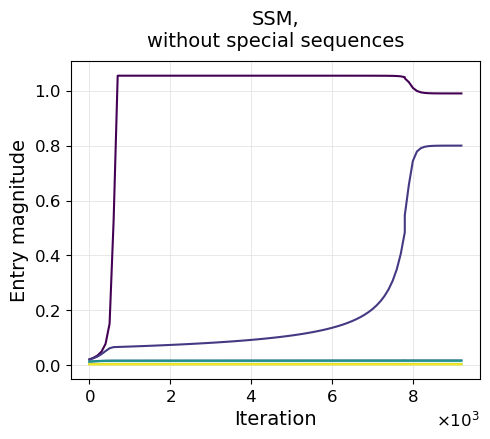

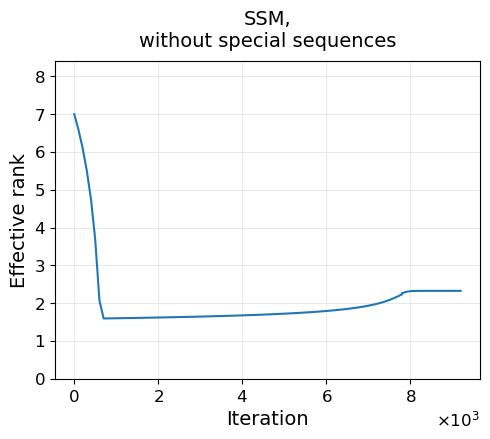

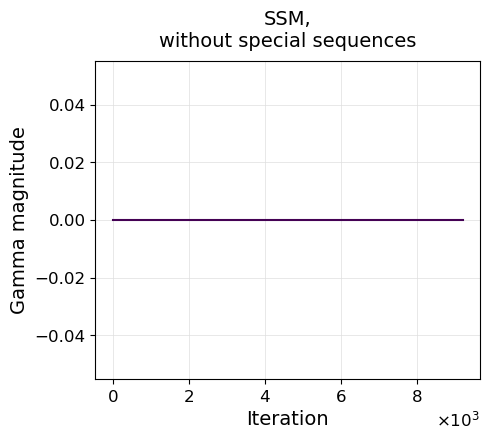

In [7]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, title=title)

## 8 baseline inputs, 10 special inputs

In [8]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length-1, :] = 1
title = 'SSM,\nwith special sequences'

In [9]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 3.4367923736572266
7 absolute largest EVs of A: [0.02140497 0.02049127 0.01326311 0.0128022  0.00455841 0.0034793  0.00329693]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009907098487019539
7 absolute largest EVs of A: [1.0478063  0.41335836 0.10835364 0.10247396 0.03554103 0.02972695 0.02878478]
+-------------+
|Final results|
+-------------+
Train loss: 0.006319083739072084
7 absolute largest EVs of A: [1.0504042  0.47379917 0.09593445 0.089834   0.0218051  0.01597707 0.01503318 0.0125318  0.01189507 0.00435177]
------------------------------------------------------------------------------------------------------
------------------------------------------------------

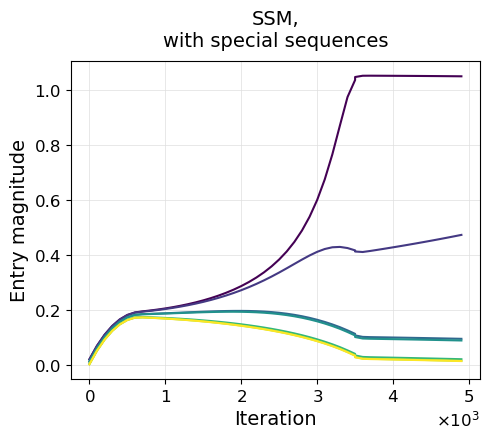

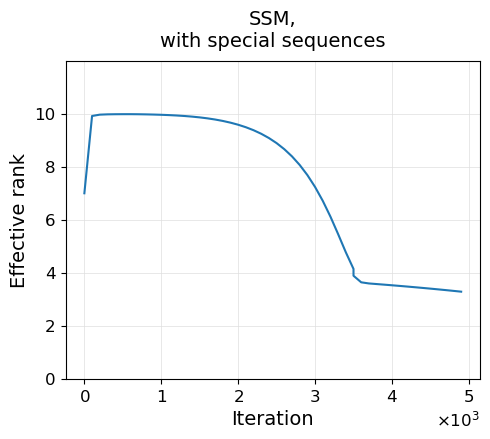

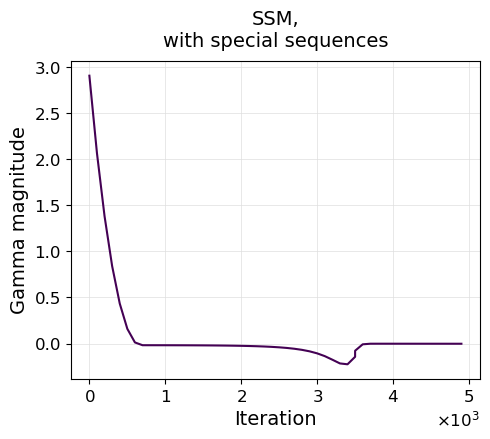

In [10]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, title=title)

# Length = 10, teacher state dim = 2, student state dim = 20

## Shared setup

In [11]:
seed = 1202
teacher_state_dim = 2
student_state_dim = 20
sd_A = 0.01
sd_B_C = 0.001
length = 10
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(3 * np.log10(1 / sd_A))

In [12]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 0.99
A[1, 1] = 0.8
B[0, 0] = 1
B[0, 1] = 1
C[0, 0] = 1
C[1, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

## 8 baseline inputs, 0 special inputs

In [13]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
title = 'SSM,\nwithout special sequences'

In [14]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 12.511759757995605
7 absolute largest EVs of A: [0.02232405 0.02220013 0.01623535 0.01574373 0.01383059 0.01363042 0.01098979]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009867263957858086
7 absolute largest EVs of A: [1.0040841  0.74444234 0.05188361 0.04711919 0.0332303  0.03208973 0.02045867]
+-------------+
|Final results|
+-------------+
Train loss: 1.5781669162606704e-06
7 absolute largest EVs of A: [9.8994255e-01 7.9990488e-01 5.1981006e-02 4.7199361e-02 3.3268411e-02 3.2125279e-02 2.0472469e-02 1.8619057e-02 1.7075118e-02 1.1880650e-02 6.1265184e-03 5.3043738e-03 4.5897826e-03 4.4277883e-03
 4.1296692e-03 3.1355862e-03 2.2673977e-03 1.3900968e-03 9.0125256e-04

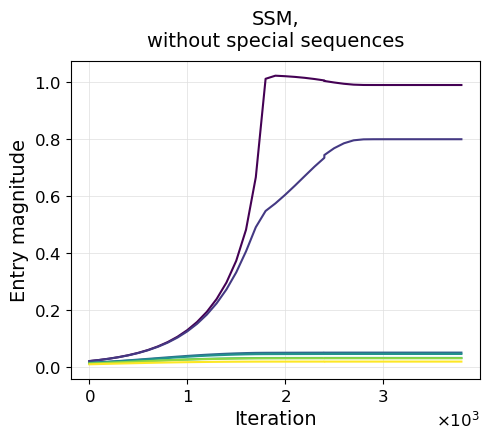

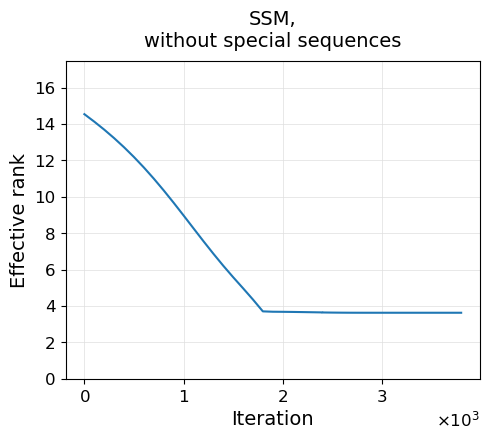

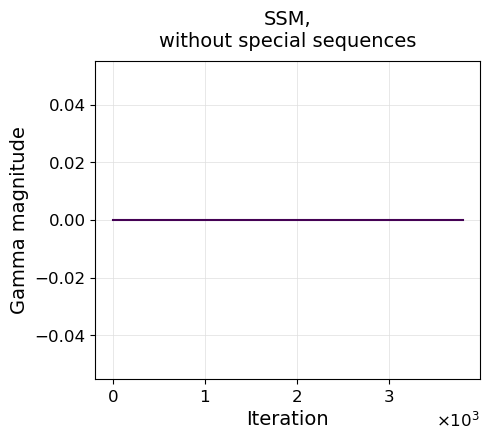

In [15]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, title=title)

## 8 baseline inputs, 10 special inputs

In [16]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length-1, :] = 1
title = 'SSM,\nwith special sequences'

In [17]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 6.875060081481934
7 absolute largest EVs of A: [0.02232413 0.02220029 0.01623562 0.01574374 0.0138307  0.01363057 0.01098984]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009883955121040344
7 absolute largest EVs of A: [1.0053718  0.73522484 0.11798704 0.10652787 0.07015328 0.0669394  0.04176861]
+-------------+
|Final results|
+-------------+
Train loss: 8.843253453960642e-07
7 absolute largest EVs of A: [0.990064   0.7994673  0.11066497 0.09909579 0.06247139 0.0592416  0.04954565 0.04775045 0.04570487 0.04207274 0.03852557 0.03452187 0.03333279 0.03268895 0.02986683 0.02665704 0.02400906 0.01796604
 0.0128311  0.00519331]
----------------------------------------------

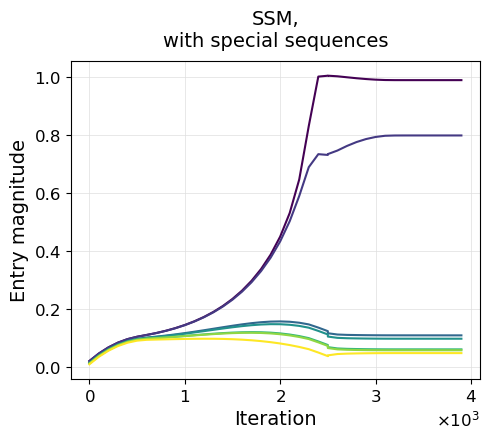

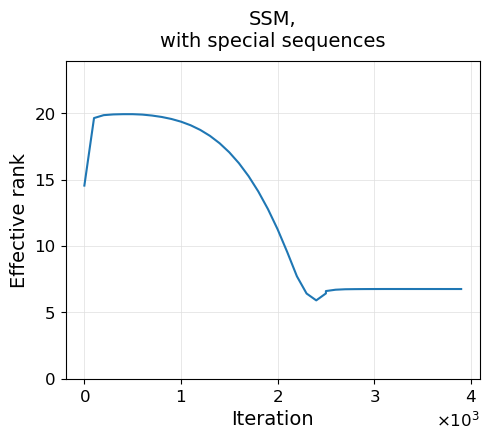

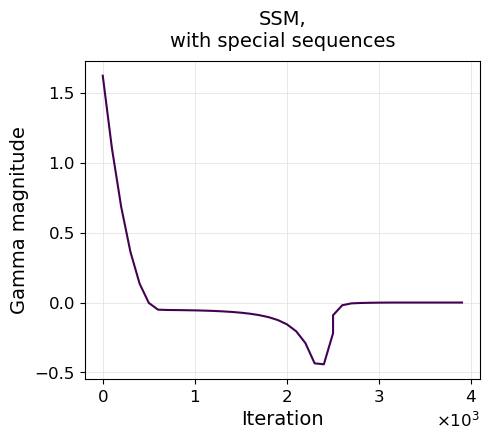

In [18]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, title=title)